In [16]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import gaussian_kde
import sys
from tqdm import tqdm
import torch

plt.rcParams['font.family'] = 'Times New Roman'


In [17]:
curr_num_runs = 100

# Sample from GMM

In [3]:
def generate_samples_from_gmm(means, covariances, n_samples):
    """
    means:       shape (n_components, n_dimensions)
    covariances: shape (n_components, n_dimensions),
                 each row is the diagonal of the covariance matrix for that component
    n_samples:   number of samples to generate in total
    """
    n_components, n_dimensions = means.shape
    samples = np.zeros((n_samples, n_dimensions))
    # Assume uniform mixing weights for simplicity
    component_choices = np.random.choice(
        n_components, size=n_samples, p=np.ones(n_components)/n_components
    )

    for i, comp in enumerate(component_choices):
        # Use np.diag(...) so each component's covariance is diagonal
        cov = np.diag(covariances[comp])
        samples[i, :] = np.random.multivariate_normal(means[comp], cov)
    return samples

# 2 Dimension

In [8]:
# Set Seed for reproducibility
np.random.seed(42)

In [9]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 2
n_truth_samples = 5000  # Number of ground truth samples
num_posterior_samples = 5000  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
# shift_magnitudes = np.arange(-3, 4, 1)  # Shift values from -3 to 3  # Shift values from -10 to 10
shift_magnitudes = [-6, -3, 0, 3, 6]  # Example shift magnitudes for testing
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"

epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

Shift magnitudes: [-6, -3, 0, 3, 6]


Generating Shifted GMMs: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


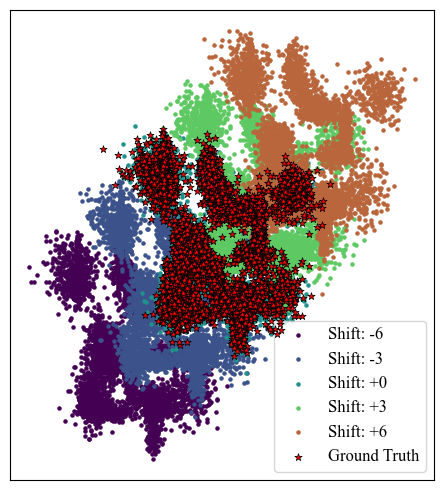

In [23]:
def gmm_full_overlay(models_normalized, truth_data_normalized, shift_magnitudes):
    """
    Overlay all ground truth samples and all posterior samples (for all shifts).
    Color encodes shift level. Ground truth shown in red.
    """
    fig, ax = plt.subplots(figsize=(8, 5)) # 12 is width, 5 is height

    num_models = len(shift_magnitudes)
    n_truth_samples = truth_data_normalized.shape[0]
    colors = [
        '#440154',  # deep purple
        '#3b528b',  # indigo blue
        '#21918c',  # teal
        '#5ec962',  # green
        "#b9663c",  # burnt orange
    ]

    # Plot posterior samples for each shift
    for i, shift in enumerate(shift_magnitudes):
        samples = models_normalized[i, 0, :, :]
        ax.scatter(samples[:, 0], samples[:, 1],
                   alpha=1.0, s=5, color=colors[i], label=f'Shift: {shift:+d}')
    
    # Plot all ground truth samples
    ax.scatter(truth_data_normalized[:, 0], truth_data_normalized[:, 1],
               color='red', s=30, marker='*', edgecolor='black', linewidth=0.5,
               label='Ground Truth', zorder=10)

    # Aesthetic settings
    ax.set_aspect('equal')
    # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])
    # Shared legend
    ax.legend(loc='lower right', fontsize=12)
    
    plt.tight_layout()
    return fig

fig2D = gmm_full_overlay(models_normalized, truth_data_normalized, shift_magnitudes)
fig2D.savefig('./PNG_Plots/GMM_Distribution_Plot.png', dpi = 300, bbox_inches='tight')
fig2D.savefig('./PDF_Plots/GMM_Distribution_Plot.pdf', dpi = 300, bbox_inches='tight')
plt.show()